In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import IncrementalPCA
import sklearn.metrics as skm

from src.data.preprocess_templates import *
from src.evaluation.visualize import *

In [2]:
REPO_PATH = "/Users/johnzhou/research/spike-sorting"
cluster_templates = np.load(f"{REPO_PATH}/data/processed/clusters_k=20/templates.npy")
cluster_labels = np.load(f"{REPO_PATH}/data/processed/clusters_k=20/unit_idxs.npy")
featurize_templates = np.load(f"{REPO_PATH}/data/processed/featurization_train/templates.npy")

geom_array = np.load(f"{REPO_PATH}/data/raw/channel_map_np2.npy")
n_channels = 20
channels_pos = geom_array[:n_channels]

### Evaluate clusters

In [7]:
num_latents = 6
print(featurize_templates.shape)
num_samples, num_timesteps, num_channels = featurize_templates.shape
templates_flat = np.reshape(featurize_templates, (num_samples, num_timesteps * num_channels))
ipca = IncrementalPCA(n_components=num_latents)
ipca.partial_fit(templates_flat)

(80000, 20, 121)


IncrementalPCA(n_components=6)

In [8]:
num_samples, num_channels, num_timesteps = cluster_templates.shape
print(cluster_templates.shape)
cluster_templates_flat = np.reshape(cluster_templates, (num_samples, num_timesteps * num_channels))
latent_rep = ipca.transform(cluster_templates_flat)

(20000, 20, 121)


In [9]:
cluster_unique, unique_idxs = np.unique(cluster_labels, return_index=True)
idx_bounds = np.sort(unique_idxs)[1:]
clusters = np.split(cluster_labels, idx_bounds)
clusters = np.vsplit(latent_rep, idx_bounds)
print([cluster.shape for cluster in clusters])

[(1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6), (1000, 6)]


In [10]:
from scipy.spatial.distance import cdist

num_clusters = len(clusters)
neg_conf_matrix = np.zeros((num_clusters, num_clusters))
eval_metric = 'l2'

for i, cluster_a in enumerate(clusters):
    for j, cluster_b in enumerate(clusters):
        inter_cluster_dists = pairwise_distances(cluster_a, cluster_b, metric=eval_metric)
        avg_inter_cluster_dist = np.mean(inter_cluster_dists)
        neg_conf_matrix[i, j] = avg_inter_cluster_dist
        neg_conf_matrix[j, i] = avg_inter_cluster_dist

avg_intra_cluster_dists = np.mean(np.diagonal(neg_conf_matrix))
neg_conf_matrix /= avg_intra_cluster_dists

min_dist = np.min(neg_conf_matrix, axis=0)
rearrange = np.argsort(min_dist)
neg_conf_matrix = neg_conf_matrix[rearrange, :]
neg_conf_matrix = neg_conf_matrix[:, rearrange]
print("min:", np.min(neg_conf_matrix), "max:", np.max(neg_conf_matrix), 
      "median:", np.median(neg_conf_matrix), "mean:", np.mean(neg_conf_matrix))

min: 0.36487569230917694 max: 7.740368570859047 median: 2.2814013658085868 mean: 3.191934785350568


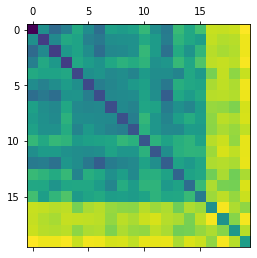

In [11]:
plt.matshow(np.log(neg_conf_matrix))

/Users/johnzhou/anaconda3/envs/yass/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


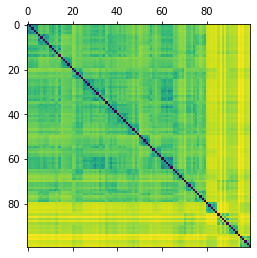

In [12]:
import math
five_from_each = [cluster[:5, :] for cluster in clusters]
five_from_each = np.stack(five_from_each)
# Sort by same min dist as clusters
five_from_each = np.reshape(five_from_each[rearrange, :, :], (100, 6))
fives_neg_conf_matrix = pairwise_distances(five_from_each, metric=eval_metric)
log_matrix = np.log(fives_neg_conf_matrix)
log_matrix[np.where(np.isneginf(log_matrix))] = 0
plt.matshow(log_matrix)

In [13]:
spike_idx = np.random.randint(fives_neg_conf_matrix.shape[0])
print(spike_idx)
neighbors = np.argsort(fives_neg_conf_matrix[spike_idx, :])
print(neighbors)

45
[45 46 48 49 65 47 66 44 22 67 24 39 38 42 40 36 75 23 43 74 78 37 62 72
 71 32 41 35 56 79  6 69 64 12 60 59  8 21  9 68 10 61 77 13  5  7 58 63
 28 30 11 73 54 20 33 57 14 34 55 52 26  1 16  2 76 19 53 31  4 27 29  3
 25  0 18 17 51 15 70 50 91 89 87 93 90 92 97 80 85 83 98 81 99 82 84 95
 88 96 86 94]


(5, 121, 20)


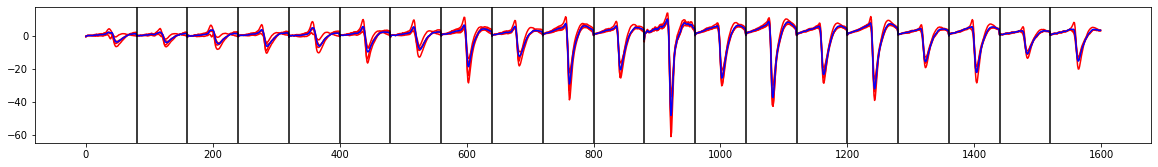

In [14]:
closest = five_from_each[neighbors[:5], :]
furthest = five_from_each[neighbors[-5:], :]
close_reconstructions = np.reshape(ipca.inverse_transform(closest), (5, num_channels, num_timesteps))
close_reconstructions = np.swapaxes(close_reconstructions, 1, 2)
print(close_reconstructions.shape)
fig = plt.figure(figsize=(n_channels, 2.5))
for i in range(1, 5):
    plt.plot(close_reconstructions[i, :80, :].T.flatten(), color='red')
plt.plot(close_reconstructions[0, :80, :].T.flatten(), color='blue')

for j in range(n_channels - 1):
    plt.axvline(80 + 80 * j, color='black')